**Comprehensive Dataset Overview and Cryptocurrency Extraction**

In [3]:
import pandas as pd
from pathlib import Path

# === 1. Load dataset ===
DATA_PATH = Path("master_dataset.csv")
df = pd.read_csv(DATA_PATH)

# === 2. Identify posts and comments based on 'unified_id' ===
def classify_post_type(unified_id: str) -> str:
    if unified_id.startswith("p_"):
        return "post"
    elif unified_id.startswith("c_"):
        return "comment"
    return "unknown"

df["type"] = df["unified_id"].astype(str).apply(classify_post_type)

# === 3. Compute counts ===
total_posts = (df["type"] == "post").sum()
total_comments = (df["type"] == "comment").sum()

distinct_posts = df.loc[df["type"] == "post", "unified_id"].nunique()
distinct_comments = df.loc[df["type"] == "comment", "unified_id"].nunique()

# === 4. Convert 'created_date' to datetime ===
df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
date_min = df["created_date"].min()
date_max = df["created_date"].max()

# === 5. Count sources if available ===
source_counts = df.get("source_platform", pd.Series()).value_counts().to_dict()
if not source_counts:
    source_counts = {"Info": "No 'source_platform' column found"}

# === 6. Extract unique cryptocurrencies from 'subreddit' ===
def extract_cryptos(column: pd.Series) -> list:
    return (
        column.dropna()
        .astype(str)
        .str.lower()
        .str.split(",")
        .explode()
        .str.strip()
        .loc[lambda x: x != ""]
        .unique()
        .tolist()
    )

crypto_unique = extract_cryptos(df["subreddit"]) if "subreddit" in df.columns else []

# === 7. Count distinct authors ===
nb_authors = df["author"].nunique()

# === 8. Display results ===
print("=== Dataset Statistics ===")
print(f"Total posts: {total_posts}")
print(f"Total comments: {total_comments}")
print(f"Distinct posts: {distinct_posts}")
print(f"Distinct comments: {distinct_comments}")
print(f"Time period: from {date_min} to {date_max}")
print(f"Sources: {source_counts}")
print(f"Number of distinct authors: {nb_authors}")

print("\n=== Cryptocurrencies extracted from 'subreddit' ===")
print(f"Number of distinct cryptos: {len(crypto_unique)}")
print("Cryptos:", crypto_unique)


=== Dataset Statistics ===
Total posts: 2320
Total comments: 26411
Distinct posts: 2319
Distinct comments: 26411
Time period: from 2025-09-29 22:06:41 to 2025-11-01 14:23:34
Sources: {'Reddit': 28731}
Number of distinct authors: 13314

=== Cryptocurrencies extracted from 'subreddit' ===
Number of distinct cryptos: 15
Cryptos: ['cryptocurrency', 'bitcoin', 'ethereum', 'solana', 'cardano', 'cryptomarkets', 'cryptotechnology', 'polkadot', 'dogecoin', 'binance', 'cryptomoonshots', 'altcoin', 'defi', 'buttcoin', 'satoshistreetbets']


**Cryptocurrency Frequency Analysis from Subreddit Column**

In [4]:
from collections import Counter
from typing import List

# === 1. Extract all cryptocurrencies listed in 'subreddit' ===
# Each cell may contain multiple names separated by commas
def extract_cryptos(subreddit_column: pd.Series) -> List[str]:
    """Extracts and normalizes cryptocurrency names from a pandas Series."""
    all_cryptos = []
    for cell in subreddit_column.dropna():
        items = [c.strip().lower() for c in str(cell).split(",") if c.strip()]
        all_cryptos.extend(items)
    return all_cryptos

# Safe column access
if "subreddit" in df.columns:
    all_cryptos = extract_cryptos(df["subreddit"])
else:
    all_cryptos = []

# === 2. Count the frequency of each cryptocurrency ===
crypto_counts = Counter(all_cryptos)

# === 3. Convert to DataFrame sorted by frequency ===
crypto_freq_df = (
    pd.DataFrame(crypto_counts.items(), columns=["crypto", "count"])
    .sort_values(by="count", ascending=False)
    .reset_index(drop=True)
)

# === 4. Display top results ===
print("=== Cryptocurrency Frequency in 'subreddit' Column ===")
print(crypto_freq_df.head(20))


=== Cryptocurrency Frequency in 'subreddit' Column ===
               crypto  count
0             bitcoin  13442
1      cryptocurrency  11313
2            ethereum   1733
3              solana   1602
4       cryptomarkets    256
5            dogecoin    139
6            buttcoin    136
7             cardano     36
8     cryptomoonshots     23
9            polkadot     20
10            altcoin     12
11               defi      8
12            binance      6
13   cryptotechnology      4
14  satoshistreetbets      1


**Text Content Length Analysis**

In [6]:
# === 4. Text Lengths ===
# Ensure the 'text_content' column exists
if "text_content" in df.columns:
    # Compute the length of each text entry
    df["text_length"] = df["text_content"].astype(str).apply(len)

    # Compute basic statistics
    text_min = df["text_length"].min()
    text_max = df["text_length"].max()
    text_mean = df["text_length"].mean()
    text_var = df["text_length"].var()

    # Display results
    print("=== Text Length Statistics ===")
    print(f"Minimum text length: {text_min}")
    print(f"Maximum text length: {text_max}")
    print(f"Mean text length: {text_mean:.2f}")
    print(f"Variance of text lengths: {text_var:.2f}")
else:
    print("Column 'text_content' not found in the dataset.")


=== Text Length Statistics ===
Minimum text length: 1
Maximum text length: 24572
Mean text length: 159.72
Variance of text lengths: 184591.75


**Percentage Distribution of Posts and Comments**

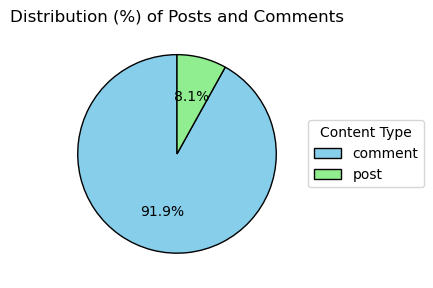

In [7]:
import matplotlib.pyplot as plt

# === Distribution (%) of posts and comments ===
if "type" in df.columns:
    # Compute percentage distribution
    type_counts = df["type"].value_counts(normalize=True) * 100

    # Create a pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(
        type_counts,
        labels=None,  # Do not put labels directly on the pie
        autopct="%1.1f%%",
        startangle=90,
        colors=["skyblue", "lightgreen"],
        wedgeprops={"edgecolor": "black"}
    )
    plt.title("Distribution (%) of Posts and Comments")

    # Add a legend to the right
    plt.legend(
        labels=type_counts.index,
        title="Content Type",
        loc="center left",
        bbox_to_anchor=(1, 0.5)  # Position legend to the right
    )

    plt.tight_layout()
    plt.show()
else:
    print("Column 'type' not found in the dataset.")


**Top 7 Most Mentioned Cryptocurrencies**

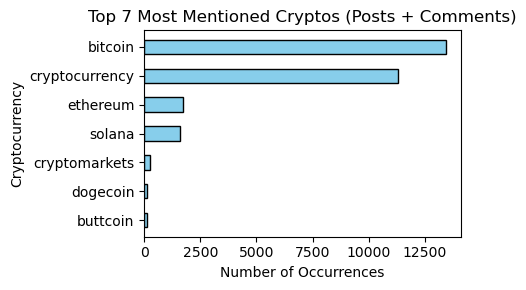

In [8]:
# === Top 7 most mentioned cryptocurrencies (posts + comments) ===
if not crypto_freq_df.empty:
    top7 = crypto_freq_df.head(7)

    plt.figure(figsize=(5, 3))
    plt.barh(
        top7["crypto"],
        top7["count"],
        color="skyblue",
        edgecolor="black",
        height=0.5  # thinner bars
    )

    plt.title("Top 7 Most Mentioned Cryptos (Posts + Comments)")
    plt.xlabel("Number of Occurrences")
    plt.ylabel("Cryptocurrency")
    plt.gca().invert_yaxis()  # Most mentioned on top

    plt.tight_layout()
    plt.show()
else:
    print("Crypto frequency DataFrame is empty.")


**Daily Trends of Posts and Comments**

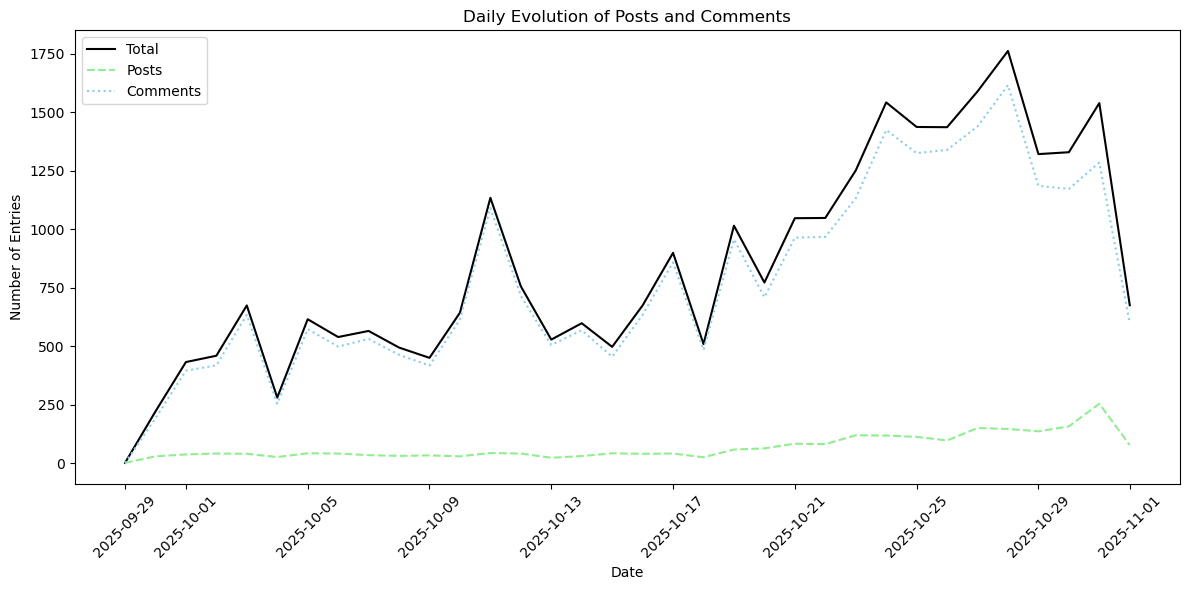

In [9]:
# === Identify posts and comments ===
if "unified_id" in df.columns:
    df["type"] = df["unified_id"].astype(str).apply(
        lambda x: "post" if x.startswith("p_") else ("comment" if x.startswith("c_") else "unknown")
    )
else:
    df["type"] = "unknown"

# === Extract date if not already done ===
if "created_date" in df.columns:
    df["date"] = pd.to_datetime(df["created_date"], errors="coerce").dt.date
else:
    df["date"] = pd.NaT

# === Count entries per day and type ===
counts_per_day = df.groupby(["date", "type"]).size().unstack(fill_value=0)

# Add a 'total' column
counts_per_day["total"] = counts_per_day.sum(axis=1)

# === Plot daily trends ===
plt.figure(figsize=(12, 6))
plt.plot(counts_per_day.index, counts_per_day["total"], label="Total", linestyle="-", color="black")
plt.plot(counts_per_day.index, counts_per_day.get("post", 0), label="Posts", linestyle="--", color="lightgreen")
plt.plot(counts_per_day.index, counts_per_day.get("comment", 0), label="Comments", linestyle=":", color="skyblue")

plt.title("Daily Evolution of Posts and Comments")
plt.xlabel("Date")
plt.ylabel("Number of Entries")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


**Posts and Comments Distribution by Cryptocurrency (Top 10)**

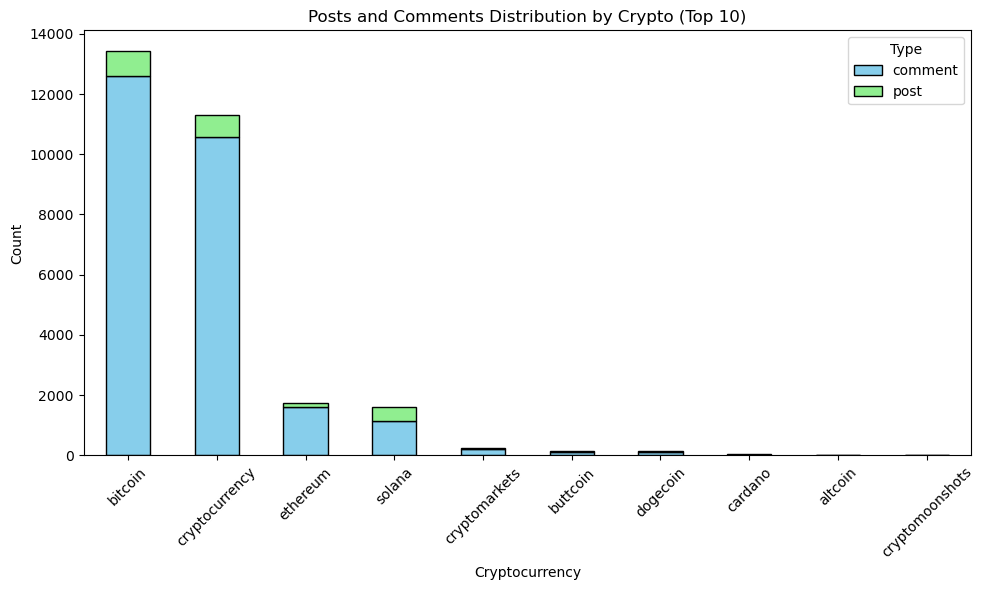

In [10]:
# === Distribution of posts and comments by cryptocurrency ===
if "subreddit" in df.columns and "type" in df.columns:
    # "Explode" the subreddit column to have one row per crypto
    df_exploded = (
        df.dropna(subset=["subreddit"])
        .assign(subreddit=df["subreddit"].str.lower().str.split(","))
        .explode("subreddit")
    )
    df_exploded["subreddit"] = df_exploded["subreddit"].str.strip()

    # Group by crypto and type
    crypto_type_counts = (
        df_exploded.groupby(["subreddit", "type"])
        .size()
        .unstack(fill_value=0)
        .sort_values(by="comment", ascending=False)
    )

    # Top 10 most active cryptos
    top_cryptos = crypto_type_counts.head(10)

    # === Stacked bar chart ===
    top_cryptos.plot(
        kind="bar",
        stacked=True,
        color=["skyblue", "lightgreen"],
        edgecolor="black",
        figsize=(10, 6)
    )

    plt.title("Posts and Comments Distribution by Crypto (Top 10)")
    plt.xlabel("Cryptocurrency")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title="Type")
    plt.tight_layout()
    plt.show()
else:
    print("Columns 'subreddit' and/or 'type' not found in the dataset.")
